# Fitting a line to correlated Gaussian data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import oktopus
from oktopus import MultivariateGaussianPosterior, MultivariateGaussianLikelihood, UniformPrior, JointPrior
from oktopus.models import ExpSquaredKernel, WhiteNoiseKernel
from matplotlib import rc
rc('text', usetex=False)
font = {'size'   : 18,}
rc('font', **font)

Text(0.5, 0, 'x')

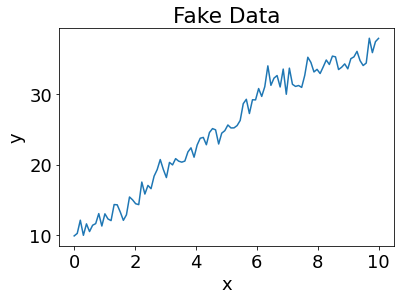

In [2]:
x = np.linspace(0, 10, 100)
def mean(m, b):
    return m * x + b
def cov(k, l, s):
    return ExpSquaredKernel(x).evaluate(k, l) + WhiteNoiseKernel(len(x)).evaluate(s)
np.random.seed(2)
fake_data = np.random.multivariate_normal(mean(3, 10), cov(1, 1, 1))
pl.plot(x, fake_data)
pl.title("Fake Data")
pl.ylabel("y")
pl.xlabel("x")

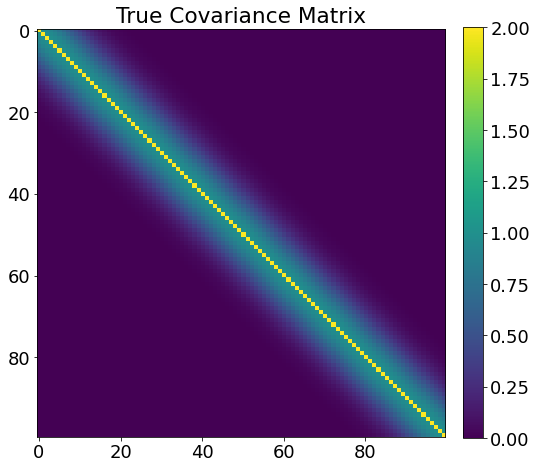

In [3]:
fig, ax = pl.subplots(figsize=(8, 14))
im = ax.imshow(cov(1, 1, 1))
ax.set_title("True Covariance Matrix")
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)

In [4]:
prior_m = UniformPrior(1, 5, 'm')
prior_b = UniformPrior(4, 15, 'b')
prior_k = UniformPrior(0, 2, 'k')
prior_l = UniformPrior(0, 2, 'l')
prior_s = UniformPrior(0, 2, 's')
prior = JointPrior(prior_m, prior_b, prior_k, prior_l, prior_s)
prior([2.5, 11, 1.3, 1.5, 0.7])

5.863631175598098

In [5]:
posterior = MultivariateGaussianPosterior(fake_data, mean, cov, 2, prior)

In [6]:
map_est = posterior.fit(x0=(2.5, 11, 1.3, 1.5, 0.7))
map_est

/Users/mackenzie/PythonProjects/ece283/ece283/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 17.785690574263032
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([-137.39735603,  -17.53388643,  -13.51653004,   41.36424565,
        231.24181724])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 55
      nit: 0
     njev: 8
   status: 2
  success: False
        x: array([ 2.5, 11. ,  1.3,  1.5,  0.7])

Text(0.5, 0, 'x')

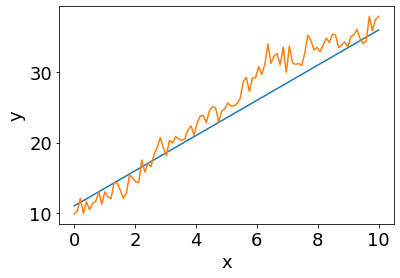

In [7]:
pl.plot(x, mean(*map_est.x[:2]))
pl.plot(x, fake_data)
pl.ylabel("y")
pl.xlabel("x")

<ipython-input-8-58944ba8db90>:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im, fraction=0.046, pad=0.04)


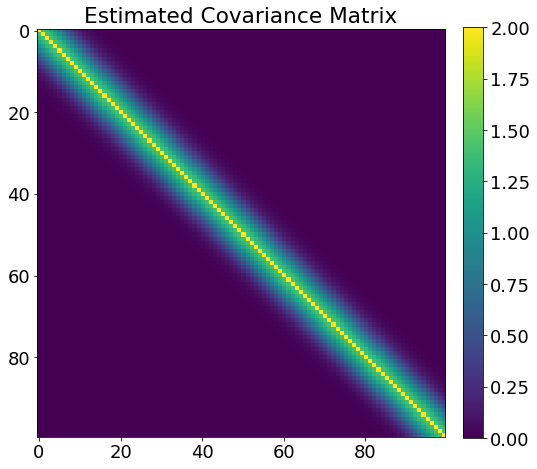

In [8]:
fig, ax = pl.subplots(figsize=(8, 14))
pl.imshow(cov(*map_est.x[2:]))
ax.set_title("Estimated Covariance Matrix")
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)

In [9]:
import emcee
ndim, nwalkers = 5, 100
p0 = [map_est.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda params: - posterior(params))
_ = sampler.run_mcmc(p0, 1000)

In [11]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples.shape

(95000, 5)

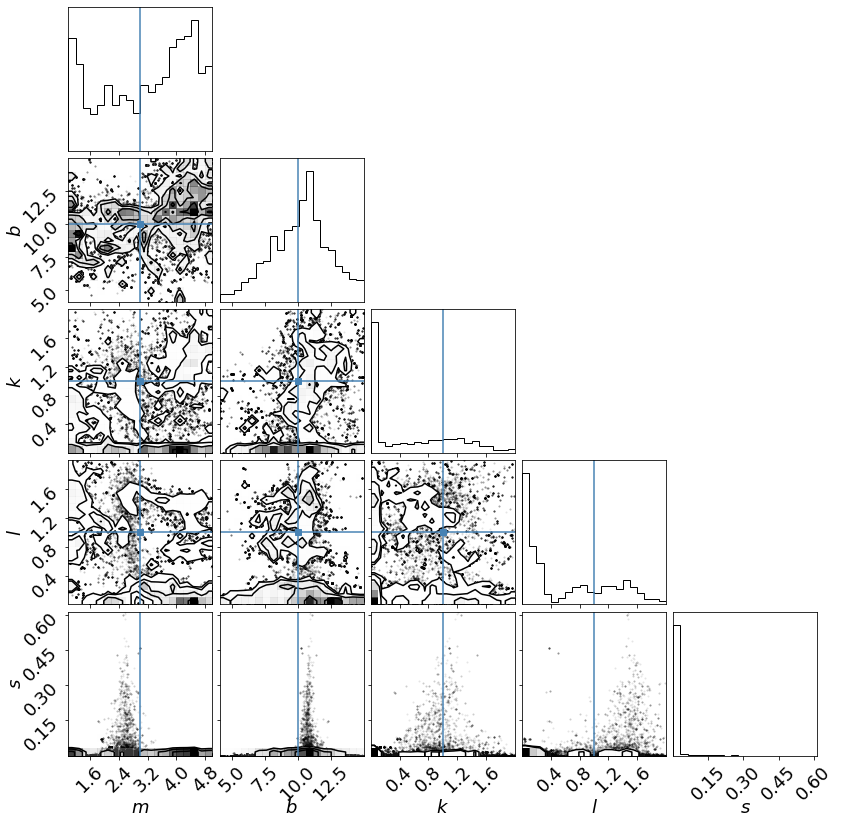

In [12]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$k$", "$l$", "$s$"],
                    truths=[3, 10, 1, 1, 1])

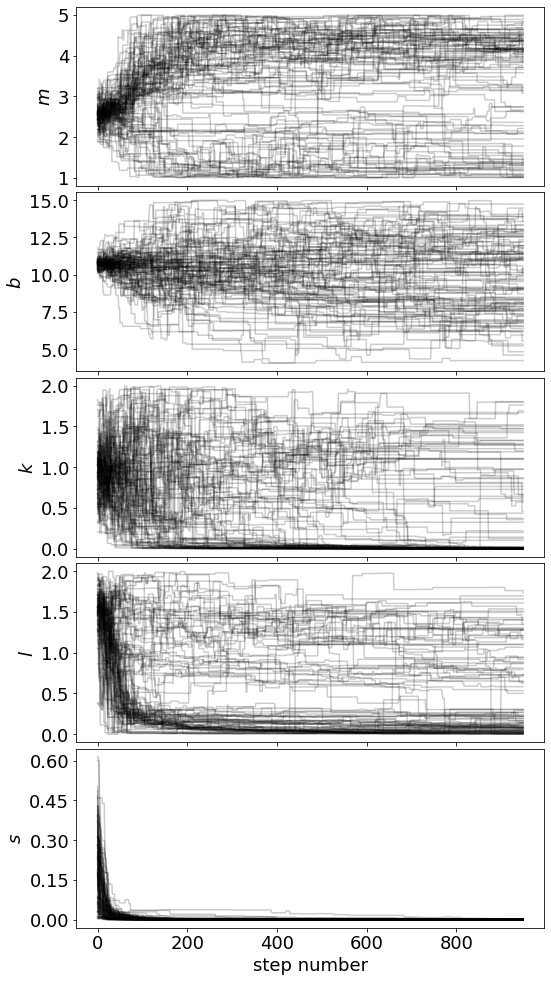

In [13]:
from matplotlib.ticker import MaxNLocator
label = ["$m$", "$b$", "$k$", "$l$", "$s$"]

fig, axes = pl.subplots(5, 1, sharex=True, figsize=(8, 14))
for i in range(0, 5, 1):
    axes[i].plot(sampler.chain[:, 50:, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(label[i])

axes[4].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)